<a href="https://colab.research.google.com/github/rsanchezgarc/AI-ML-analytics-IE/blob/main/notebooks%20/competitions/baseline_twitter_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baseline solution to the twitter-emotion-classification competition.
The code contain a few #TODOs that could help you obtaining a better model

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

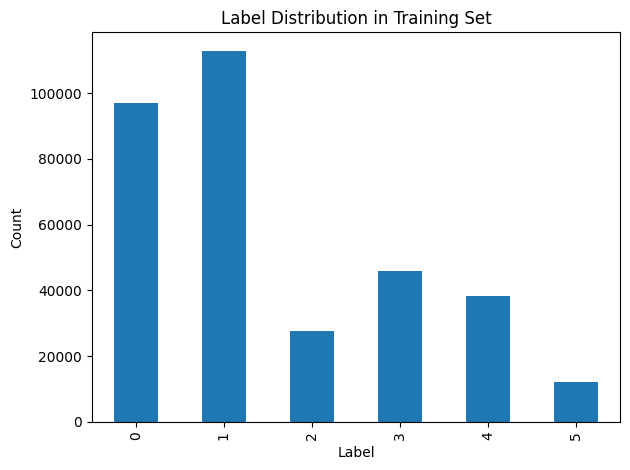

In [20]:
# Load data
train = pd.read_csv('train_kaggle.csv')
test  = pd.read_csv('test_kaggle.csv')

# -------------------------
# Visualization: Label Distribution
# -------------------------
label_counts = train['label'].value_counts().sort_index()
plt.figure()
label_counts.plot(kind='bar')
plt.title('Label Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Placeholder functions for preprocessing
def clean_data(df):
    """
    TODO: implement text cleaning
    - lowercase conversion
    - remove punctuation, URLs
    - remove stopwords / lemmatization
    """
    return df


def remove_outliers(df):
    """
    TODO: identify and remove outlier texts (e.g., extremely long/short tweets)
    - consider trimming or filtering by length
    """
    return df

# Apply cleaning and filtering
train = clean_data(train)
train = remove_outliers(train)
test  = clean_data(test)

# Text & labels
text_column   = 'text'
target_column = 'label'

X      = train[text_column].tolist()
y      = train[target_column].tolist()
X_test = test[text_column].tolist()

# Encode labels
label_encoder = LabelEncoder()
y_encoded     = label_encoder.fit_transform(y)
num_classes   = len(label_encoder.classes_)

# Vocabulary builder
# Hint: you can replace this with pretrained embeddings (e.g., GloVe)
# TODO: You can also try BPE
def build_vocab(texts, max_vocab_size=10000):
    counter = Counter()
    for text in texts:
        counter.update(text.lower().split())
    most_common = counter.most_common(max_vocab_size - 2)
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
    vocab['<PAD>'] = 0
    vocab['<OOV>'] = 1
    return vocab

vocab = build_vocab(X)

# Text encoder to fixed-length sequences
def encode_text(texts, vocab, max_length=200):
    sequences = []
    for text in texts:
        tokens = text.lower().split()
        seq    = [vocab.get(tok, vocab['<OOV>']) for tok in tokens]
        if len(seq) < max_length:
            seq += [vocab['<PAD>']] * (max_length - len(seq))
        else:
            seq = seq[:max_length]
        sequences.append(seq)
    return torch.tensor(sequences)

X_encoded      = encode_text(X, vocab)
X_test_encoded = encode_text(X_test, vocab)

# Train / Validation split
test_size = 0.2
seed      = 42
X_train, X_val, y_train, y_val = train_test_split(
    X_encoded,
    y_encoded,
    test_size=test_size,
    random_state=seed,
    stratify=y_encoded
)

y_train = torch.tensor(y_train)
y_val   = torch.tensor(y_val)

# Dataset class
class TextDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

# DataLoaders
batch_size   = 64
train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TextDataset(X_val,   y_val),   batch_size=batch_size)
test_loader  = DataLoader(TextDataset(X_test_encoded), batch_size=batch_size)

In [28]:
# Model definition
class MyModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab['<PAD>'])
        #TODO: a simple RNN is not very powerful, try a GRU or an LSTM
        self.rnn       = nn.RNN(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        # TODO: add dropout layer here for regularization
        self.fc        = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        emb = self.embedding(x)
        _, h = self.rnn(emb)
        # Combine bidirectional hidden states
        h = torch.cat([h[-2], h[-1]], dim=1)
        # Hint: try adding a dropout here
        out = self.fc(h)
        return out

# Instantiate model
env_vocab_size = len(vocab)
embed_dim       = 100
hidden_dim      = 128
model           = MyModel(env_vocab_size, embed_dim, hidden_dim, num_classes).to(device)

# Loss & optimizer
# Hint: try class-weighted or focal loss to address imbalance
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# TODO: add LR scheduler (e.g., ReduceLROnPlateau or StepLR)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss    = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss    = 0.0
    y_val_preds = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs        = model(inputs)
            loss           = criterion(outputs, targets)
            val_loss      += loss.item() * inputs.size(0)
            y_val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_f1       = f1_score(y_val.numpy(), np.array(y_val_preds), average='macro')

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {val_f1:.4f}")

# TODO: add early stopping based on val_f1
# TODO: after training, plot learning curves (loss vs epoch)

# Test inference
model.eval()
test_preds = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())

# Create submission
submission = pd.DataFrame({'ID': test.index, 'label': label_encoder.inverse_transform(test_preds)})
submission.to_csv('submission_pytorch.csv', index=False)
print("Submission file created: submission_pytorch.csv")

# BONUS HINTS:
# - Try plotting a confusion matrix with sklearn.metrics.confusion_matrix
# - Experiment with Hugging Face Transformers for better performance
# - Perform hyperparameter search (e.g., learning rates, hidden sizes) using Ray Tune or Optuna


Epoch 1/10 | Train Loss: 1.4981 | Val Loss: 1.4240 | Val F1: 0.1969
Epoch 2/10 | Train Loss: 1.0495 | Val Loss: 1.4491 | Val F1: 0.2349
Epoch 3/10 | Train Loss: 0.9074 | Val Loss: 0.7139 | Val F1: 0.5529
Epoch 4/10 | Train Loss: 0.8485 | Val Loss: 0.9651 | Val F1: 0.4492
Epoch 5/10 | Train Loss: 0.8191 | Val Loss: 0.9285 | Val F1: 0.4343
Epoch 6/10 | Train Loss: 0.8634 | Val Loss: 0.6489 | Val F1: 0.6240
Epoch 7/10 | Train Loss: 0.8900 | Val Loss: 0.8959 | Val F1: 0.5602
Epoch 8/10 | Train Loss: 0.7478 | Val Loss: 0.6468 | Val F1: 0.5769
Epoch 9/10 | Train Loss: 0.6652 | Val Loss: 0.5256 | Val F1: 0.6557
Epoch 10/10 | Train Loss: 0.5852 | Val Loss: 0.7172 | Val F1: 0.5737
Submission file created: submission_pytorch.csv
